In [15]:
import pickle
import random 
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
'''
Epoch: 50 - Validation
| Epoch: 50 |
| Train Loss: 8.328 | Train Precision: 0.001 | Train Recall: 0.001 | Train F1: 0.001 | Train Acc: 0.13% |
| Val. Loss: 16.218 | Val. Precision: 0.001 | Val. Recall: 0.001 | Val. F1: 0.001 | Val. Acc: 0.12% |
128, 10
Testing
| Test Loss: 11.748 | Test Precision: 0.002 | Test Recall: 0.002 | Test F1: 0.002 | Test Acc: 0.24% |
512, 5
Testing
| Test Loss: 11.962 | Test Precision: 0.003 | Test Recall: 0.003 | Test F1: 0.003 | Test Acc: 0.26% |
1024, 3
Testing
| Test Loss: 12.032 | Test Precision: 0.002 | Test Recall: 0.002 | Test F1: 0.002 | Test Acc: 0.20% |

'''

# 1. Explore parsed data set 

In [829]:
DATA_DIR = '../AST-parsing/Data/'
#DATASET = 'data_large/'
DATASET = 'data_numpy_pandas_sklearn_width_100_20/'
#DATASET = 'data_numpy_pandas_sklearn/'
#DATASET = 'data_numpy/'
#DATASET = 'data_small/'
print(DATA_DIR + DATASET)

../AST-parsing/Data/data_numpy_pandas_sklearn_width_100_20/


In [830]:
with open(DATA_DIR + DATASET + 'parsed/dictionaries', 'rb') as file:
    N_methods = pickle.load(file)
    word_to_counts = pickle.load(file)
    path_to_counts = pickle.load(file)
    target_to_counts = pickle.load(file)
    path_dictionary = pickle.load(file)
    #contexts= pickle.load(file)

In [831]:
methods = []
with open(DATA_DIR + DATASET + 'parsed/methods', 'rb') as file:
    for line in file:
        methods.append(line.decode('utf-8', 'surrogatepass').strip('\n').strip(' ').split(' '))

In [832]:
train = []
test = []
validation = []
with open(DATA_DIR + DATASET + 'split/train', 'rb') as file:
    for line in file:
        train.append(line.decode('utf-8', 'surrogatepass').strip('\n').strip(' ').split(' '))
with open(DATA_DIR + DATASET + 'split/test', 'rb') as file:
    for line in file:
        test.append(line.decode('utf-8', 'surrogatepass').strip('\n').strip(' ').split(' '))
with open(DATA_DIR + DATASET + 'split/validation', 'rb') as file:
    for line in file:
        validation.append(line.decode('utf-8', 'surrogatepass').strip('\n').strip(' ').split(' '))

In [833]:
print(len(train), len(test), len(validation))

21564 2696 2696


In [834]:
N_methods

26956

In [835]:
np.max([len(i)-1 for i in methods])

25471

In [836]:
#methods[1]

In [396]:
#path_dictionary

In [397]:
#word2count

DescribeResult(nobs=45378, minmax=(1, 2913863), mean=761.3782449645203, variance=397870270.6374553, skewness=94.25425064015968, kurtosis=11540.713299883217)

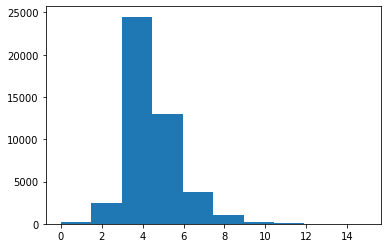

In [837]:
#plt.hist(word_to_counts.values())
plt.hist([np.log(i) for i in word_to_counts.values()])
stats.describe([i for i in word_to_counts.values()])

DescribeResult(nobs=1743818, minmax=(1, 200270), mean=9.906372683387831, variance=98190.39643068149, skewness=310.0125737165988, kurtosis=139993.33779267903)

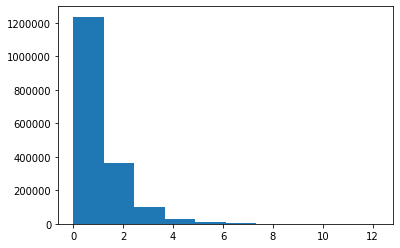

In [838]:
#plt.hist(path_to_counts.values())
plt.hist([np.log(i) for i in path_to_counts.values()])
stats.describe([i for i in path_to_counts.values()])

DescribeResult(nobs=25732, minmax=(1, 31), mean=1.0475672314627702, variance=0.16298541481829576, skewness=25.968880967850225, kurtosis=1382.1296910060828)

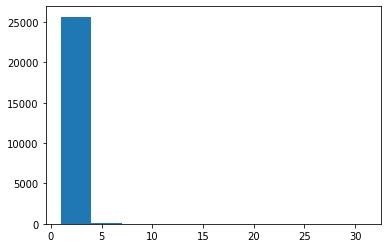

In [839]:
plt.hist(target_to_counts.values())
#plt.hist([np.log(i) for i in target_to_counts.values()])
stats.describe([i for i in target_to_counts.values()])

In [ ]:
# target in train, and test 

In [840]:
with open(DATA_DIR + DATASET + 'split/dictionaries_train', 'rb') as file:
    N_train = pickle.load(file)
    word_to_counts_train = pickle.load(file)
    path_to_counts_train = pickle.load(file)
    target_to_counts_train = pickle.load(file)
with open(DATA_DIR + DATASET + 'split/dictionaries_else', 'rb') as file:
    pickle.load(file)
    pickle.load(file)
    pickle.load(file)
    word_to_counts_test = pickle.load(file)
    path_to_counts_test = pickle.load(file)
    target_to_counts_test = pickle.load(file)

In [841]:
shared_targets = []
for target in target_to_counts_test.keys():
    if target in target_to_counts_train.keys():
        shared_targets.append(target)        

In [842]:
len(shared_targets)/len(test)

0.05934718100890208

# 2. Split Data 

In [843]:
print(len(train), len(test), len(validation))

21564 2696 2696


# 3. Code Embeddings

In [ ]:
# Epoch: 300 - Validation (data_small)
# 3
# | Epoch: 300 |
# | Train Loss: 5.309 | Train Precision: 0.793 | Train Recall: 0.780 | Train F1: 0.786 | Train Acc: 66.91% |
# | Val. Loss: 5.967 | Val. Precision: 0.034 | Val. Recall: 0.078 | Val. F1: 0.048 | Val. Acc: 2.22% |
# Testing
# 3
# | Test Loss: 5.933 | Test Precision: 0.068 | Test Recall: 0.127 | Test F1: 0.089 | Test Acc: 4.44% |

In [844]:
from sklearn.neighbors import NearestNeighbors
from random import sample
import ast
import torch
import torch.nn as nn
import os

In [ ]:
def string2array(string):
    array = []
    temp = string.split('_')
    for item in temp:
        list_temp = item.split('||')
        for i in list_temp:
            array.append(i)
    return array
# check if string2 contains any keywords in string1
def keywords_shared(string1, string2):
    total = 0
    array1 = string2array(string1)
    array2 = string2array(string2)
    for item in array2:
        if item in array1:
            total += 1
    return total

In [1114]:
DATA_DIR = '../AST-parsing/Data/'
#DATASET = 'data_numpy_pandas_sklearn/'
DATASET = 'data_numpy_pandas_sklearn_width_100_20'
#DATASET = 'data_numpy'
#DATASET = 'data_numpy_width10'
#DATASET = 'data_small'
print(DATA_DIR + DATASET)

../AST-parsing/Data/data_numpy_pandas_sklearn_width_100_20


## 3.1 code embeddings for train

In [1115]:
# Embeddings trained on DATASET
# with open('IR_'+ DATASET+'_IgVal', 'rb') as file:
#     vectors = pickle.load(file)
with open('IR_'+ DATASET+'_wVal', 'rb') as file:
    vectors_train = pickle.load(file)
# with open('IR/IR_'+ DATASET, 'rb') as file:
#     vectors = pickle.load(file)

In [932]:
vectors.shape

(21564, 128)

In [1110]:
train = []
with open(DATA_DIR + DATASET + '/split/train', 'rb') as file:
    for line in file:
        train.append(line.decode('utf-8', 'surrogatepass').strip('\n').strip(' ').split(' '))
n_train = len(train)
print(n_train)

label = [item[0] for item in train]
print(label[0:10])

21564
['test_min_samples_leaf', 'TestDatetimeArray||test_array_interface', 'check_dtype', '_prf_divide', 'TimeDeltaBlock||__init__', 'TestDatetimeIndex||test_asarray_tz_naive', 'TestSeriesQuantile||test_datetime_timedelta_quantiles', 'test_is_interval_dtype', 'nanpercentile', 'DatetimeLikeArrayMixin||freq']


### (1) Metric 1: check k-NN for a subset of randomly selected methods in train, calculate the average of numbers of common keywords

In [1489]:
# find k-nn
N_neighbors = 11
nbrs = NearestNeighbors(n_neighbors=N_neighbors, algorithm='ball_tree').fit(vectors_train)

In [1490]:
# randomly select some methods, and check their knn
N_keywords = [-1.0 for _ in range(100)]
subset = sample(range(0, n_train), 100)
distances, indices = nbrs.kneighbors(vectors_train[subset,])
for i, row in enumerate(indices):
    method1 = label[row[0]]
    N_method1 = len(string2array(method1))
    for item in row:
        print (label[item])
        keywords_common = keywords_shared(method1, label[item])
        print(keywords_common)
        #print(keywords_common/N_method1)
        #N_keywords[i] = N_keywords[i] + keywords_common/N_method1
        N_keywords[i] = N_keywords[i] + keywords_common
    N_keywords[i] = N_keywords[i] / N_neighbors
    print('\n')

mintypecode
1
TestPercentile||test_api
0
TestLimits||test_max_map_len
0
TestSeriesConstructors||test_constructor_dict_nan_key
0
TestLimits||test_max_str_len
0
fftfreq
0
test_predict_transform_copy
0
test_iter_buffering_string
0
TestSparseDataFrame||test_constructor_dict_order
0
init_ndarray
0
TestMultiIndexSetItem||test_multiindex_assignment
0


versions_from_parentdir
3
test_warm_start_yields_identical_results
0
contingency_matrix
0
TestRegression||test_who_with_0dim_array
0
test_iforest_warm_start
0
check_decision_proba_consistency
0
check_estimators_partial_fit_n_features
0
TestMultiIndexSetItem||test_multiindex_assignment
0
validate_cum_func_with_skipna
0
test_to_integer_array_error
0
test_group_selection_cache
0


SparseArray||npoints
2
FrameApply||columns
0
CategoricalIndex||_formatter_func
0
TfidfVectorizer||sublinear_tf
0
ExtensionBlock||_can_hold_na
0
Block||dtype
0
SparseArray||_null_fill_value
1
CategoricalIndex||categories
0
SingleBlockManager||ftype
0
DatetimeIndexOpsMixin

In [1203]:
np.array(N_keywords).mean() # average numbers of common keywords from the neariest neighbors

1.0327272727272727

### (2) Metric 2: check k-NN for all 'sort'-related methods in train, count of which how many have 'sort'-related nearest neighbors  

In [1212]:
# select all the 'sort'-related methods, then check knn
subset = []
for id, target in enumerate(label):
    if 'sort' in target:
        print(target, id)
        subset.append(id)

TestCategoricalSort||test_sort_values_na_position 105
PeriodIndex||searchsorted 106
test_simultaneous_sort 215
BaseGroupbyTests||test_groupby_extension_no_sort 281
Sort||time_argsort 298
test_sortlevel_deterministic 345
SortGenerator||sorted_block 426
TestDataFrameSortIndexKinds||test_sort_index_inplace 540
TestDataFrameSortIndexKinds||test_sort_index_intervalindex 588
Categories||time_groupby_extra_cat_sort 652
data_missing_for_sorting 689
TestCategoricalAnalytics||test_searchsorted 693
_sort_complex 786
TestSparseSeriesScipyInteraction||test_to_coo_text_names_text_row_levels_nosort 1019
DatetimeIndexOpsMixin||sort_values 1033
TestTimedeltaIndex||test_sort_values 1089
TestArrayAnalytics||test_search_sorted_datetime64_scalar 1127
TestTimedelta64ArithmeticUnsorted||test_subtraction_ops 1144
TestDataFrameSortIndexKinds||test_sort_index_categorical_index 1164
test_unsortedindex_doc_examples 1402
BaseMethodsTests||test_argsort_missing 1412
test_difference_sort_incomparable 1460
TestSortCom

In [1213]:
len(subset) # in total 218 sort-related functions 

218

In [ ]:
# find k-nn
N_neighbors = 11
nbrs = NearestNeighbors(n_neighbors=N_neighbors, algorithm='ball_tree').fit(vectors_train)

In [1268]:
distances, indices = nbrs.kneighbors(vectors_train[subset,])
# the number of key words contained in each one of the nearest neighbors (except itself)
N_keywords = [-1 for _ in range(len(indices))] 
for i, row in enumerate(indices):
    for item in row:
        print (label[item])
        if 'sort' in label[item]:
            print('**')
            N_keywords[i] += 1 
    print('\n')

TestCategoricalSort||test_sort_values_na_position
**
TestInsertIndexCoercion||test_insert_index_float64
TestTimedeltaArraylikeMulDivOps||test_td64arr_rfloordiv_tdlike_scalar
TestTimedeltaIndex||test_float64_ns_rounded
TestSeriesInterpolateData||test_nan_str_index
TestSeriesAnalytics||test_numpy_round_nan
TestInt64Index||test_join_left
TestClip||test_clip_with_out_transposed
TestTake||test_positional_take_unobserved
TestTake||test_take_allow_fill
TestRandomDist||test_normal


PeriodIndex||searchsorted
**
TimeDeltaBlock||fillna
DatetimeLikeArrayMixin||freq
ComplicatedSubArray||__getitem__
SparseArray||fill_value
TimedeltaArray||_unbox_scalar
JSONArray||__setitem__
DecimalArray||__setitem__
test_init_transformation
SuperTensorTestCase||testNormNonContainer
LoadtxtCSVDateTime||setup


test_simultaneous_sort
**
test_simultaneous_sort
**
_safe_indexing_column
TestFieldIndexing||test_scalar_return_type
test_pipeline_sample_weight_supported
test_nth_nan_in_grouper
TestDataFramePlots||test_boxp

In [1262]:
print(sum(np.array(N_keywords) > 0))
sum(np.array(N_keywords) > 0)/len(subset)

94


0.43119266055045874

### (3) Metric 3: check k-NN for an arbitrary given method

In [1425]:
import sys
sys.path.append('../AST-parsing/')
from ExtractPathContexts import extract_path_contexts_file
from Utils import string_hashcode
import models
from ExtractPathContexts import print_tree

def numericalize_method(methods, MAX_LENGTH, word2idx, path2idx):
    BATCH_SIZE = len(methods)
    examples = []
    for line in methods:
        example_name = line[0]
        if len(line) > 1:
            example_body = line[1:]
        else:
            example_body = []
        example_length = len(example_body)
        if example_length <= MAX_LENGTH:
            # need to pad all to maximum length
            # example_body += [['<pad>', '<pad>', '<pad>']]*(MAX_LENGTH - example_length)
            example_body += ['<pad>, <pad>, <pad>'] * (MAX_LENGTH - example_length)
        else:
            example_body = example_body[0: MAX_LENGTH]
        assert len(example_body) == MAX_LENGTH
        examples.append((example_name, example_body, example_length))
        
    raw_batch_name, raw_batch_body, batch_lengths = zip(*examples)
    # create a tensor to store the batch
    tensor_n = torch.zeros(BATCH_SIZE).long()  # name
    tensor_l = torch.zeros((BATCH_SIZE, MAX_LENGTH)).long()  # left node
    tensor_p = torch.zeros((BATCH_SIZE, MAX_LENGTH)).long()  # path
    tensor_r = torch.zeros((BATCH_SIZE, MAX_LENGTH)).long()  # right node
    mask = torch.ones((BATCH_SIZE, MAX_LENGTH)).float()  # mask

    # for each example in our raw data
    for j, (name, body, length) in enumerate(zip(raw_batch_name, raw_batch_body, batch_lengths)):
        # convert to idxs using vocab
        # use <unk> tokens if item doesn't exist inside vocab
        temp_n = target2idx.get(name, target2idx['<unk>'])
        # temp_l, temp_p, temp_r = zip(*[(word2idx.get(l, word2idx['<unk>']), path2idx.get(p, path2idx['<unk>']), word2idx.get(r, word2idx['<unk>'])) for l, p, r in body])
        temp_l = []
        temp_p = []
        temp_r = []
        for item in body:
            l, p, r = item.split(',')
            temp_l.append(word2idx.get(l, word2idx['<unk>']))
            temp_p.append(path2idx.get(p, path2idx['<unk>']))
            temp_r.append(word2idx.get(r, word2idx['<unk>']))

        # store idxs inside tensors
        tensor_n[j] = temp_n
        tensor_l[j, :] = torch.LongTensor(temp_l)
        tensor_p[j, :] = torch.LongTensor(temp_p)
        tensor_r[j, :] = torch.LongTensor(temp_r)

        # create masks
        mask[j, length:] = 0

    return tensor_n, tensor_l, tensor_p, tensor_r, mask

In [1438]:
# given a snippet of code, predict distribution vector of method names
code_str = "def f(a,b): \n\
\tdef g():\n\
\t\tprint('Hello world') \n\
\treturn a + b \
"
tree = ast.parse(code_str)
methods_ = extract_path_contexts_file(tree, 8, 2)

In [1584]:
with open('example.py', 'r') as source:
    tree = ast.parse(source.read())
methods_ = extract_path_contexts_file(tree, 100, 20)
methods_

[['bubbleSort',
  'self,arg_UP_arguments_DOWN_arg,arr',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_Assign_DOWN_Name,n',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_Assign_DOWN_Call_DOWN_Name,len',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_Assign_DOWN_Call_DOWN_Name,arr',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_Name,i',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_Call_DOWN_Name,range',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_Call_DOWN_Name,n',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_For_DOWN_Name,j',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_For_DOWN_Call_DOWN_Name,range',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_For_DOWN_Call_DOWN_Num,0',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_For_DOWN_Call_DOWN_BinOp_DOWN_BinOp_DOWN_Name,n',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_For_DOWN_Call_DOWN_Sub_UP_BinOp_UP_BinOp_DOWN_Sub,None',
  'self,arg_UP_arguments_UP_FunctionDef_DOWN_For_DOWN_F

In [1585]:
# hash encodes the paths
methods = []
for method in methods_:
    hashed_method = [method[0]]
    for context in method[1:]:
        context_array = context.split(',')
        path = context_array[1]
        word1 = context_array[0]
        word2 = context_array[2]
        hashed_path = str(string_hashcode(path))
        hashed_context = ','.join([word1, hashed_path, word2])
        hashed_method.append(hashed_context)
    methods.append(hashed_method)
methods

[['bubbleSort',
  'self,-2091844355,arr',
  'self,1775339075,n',
  'self,-1196982977,len',
  'self,-1196982977,arr',
  'self,-1106352473,i',
  'self,933376163,range',
  'self,933376163,n',
  'self,-328404074,j',
  'self,-1681613102,range',
  'self,-1993907617,0',
  'self,-658463790,n',
  'self,800252489,None',
  'self,-658463790,i',
  'self,800252489,None',
  'self,-2084645145,1',
  'self,-900092713,arr',
  'self,25856815,j',
  'self,-1044137558,None',
  'self,-900092713,arr',
  'self,1093886669,j',
  'self,589476612,1',
  'self,-1159293983,arr',
  'self,447199717,j',
  'self,-1159293983,arr',
  'self,-1476852137,j',
  'self,783644218,1',
  'self,-1159293983,arr',
  'self,-1476852137,j',
  'self,783644218,1',
  'self,-1159293983,arr',
  'self,447199717,j',
  'arr,1775339075,n',
  'arr,-1196982977,len',
  'arr,-1196982977,arr',
  'arr,-1106352473,i',
  'arr,933376163,range',
  'arr,933376163,n',
  'arr,-328404074,j',
  'arr,-1681613102,range',
  'arr,-1993907617,0',
  'arr,-658463790,n'

In [1586]:
# Load the trained model 
EMBEDDING_DIM = 128
DROPOUT = 0
MAX_LENGTH = 100
with open(DATA_DIR+DATASET+'/split/dictionaries_train', 'rb') as file:
    n_training_examples = pickle.load(file)
    word2count = pickle.load(file)
    path2count = pickle.load(file)
    target2count = pickle.load(file)

word2idx = {'<unk>': 0, '<pad>': 1}
path2idx = {'<unk>': 0, '<pad>': 1 }
target2idx = {'<unk>': 0, '<pad>': 1}

idx2word = {}
idx2path = {}
idx2target = {}

for w in word2count.keys():
    word2idx[w] = len(word2idx)
for k, v in word2idx.items():
    idx2word[v] = k
for p in path2count.keys():
    path2idx[p] = len(path2idx)

for k, v in path2idx.items():
    idx2path[v] = k
for t in target2count.keys():
    target2idx[t] = len(target2idx)
for k, v in target2idx.items():
    idx2target[v] = k

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.Code2Vec(len(word2count.keys())+2, len(path2count.keys())+2, EMBEDDING_DIM, \
                        len(target2count.keys())+2, DROPOUT)
model.load_state_dict(torch.load('checkpoints/'+ DATASET +'-split-model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [1587]:
list(model.parameters())[0]

Parameter containing:
tensor([[[-1.1831e-01, -2.1700e+00,  1.3544e+00,  ..., -1.2361e-02,
          -1.2236e+00,  7.4082e-01],
         [ 1.3667e-01, -9.6925e-01,  4.0888e-01,  ..., -3.9345e-01,
          -3.9054e-01, -1.4912e-03],
         [ 1.9891e+00,  4.6062e-01,  1.7564e+00,  ..., -1.4593e+00,
           1.8791e+00, -7.1309e-01],
         ...,
         [ 2.8299e-01, -1.2304e+00, -4.5626e-01,  ..., -4.5232e-01,
          -1.5598e-01, -8.2109e-01],
         [ 4.7452e-01, -1.3157e+00,  8.4152e-01,  ...,  2.1801e-01,
          -4.5200e-01, -5.5956e-01],
         [-1.8045e+00, -1.4528e-01,  6.5570e-01,  ...,  7.2073e-01,
           1.4298e+00, -8.1514e-01]]], requires_grad=True)

In [1589]:
tensor_n, tensor_l, tensor_p, tensor_r, mask = numericalize_method(methods, MAX_LENGTH, word2idx, path2idx)
#place on gpu
tensor_n = tensor_n.to(device)
tensor_l = tensor_l.to(device)
tensor_p = tensor_p.to(device)
tensor_r = tensor_r.to(device)
#get code vector
temp = model.get_code_vec(tensor_l, tensor_p, tensor_r)
vectors = temp.detach().numpy()
print(vectors.shape)
print(vectors)

(2, 128)
[[ 0.79908353  0.59082115  0.5912005  -0.60086024 -0.9999007   0.42509174
  -0.4299632   0.59080774 -0.5992699   0.4245171   0.5908965  -0.65138143
   0.5992832   0.59936893  0.5909225  -0.5992855  -0.5908052   0.36344302
   0.99136317  0.99142575  0.82534516 -0.99998724  0.99997807 -0.5908898
   0.595786   -0.9913739  -0.42482096  0.42223343  0.5745724  -0.42882702
   0.9962468   0.90915537 -0.42523554 -0.99142593 -0.94274926 -0.6509347
   0.586637    0.4166057  -0.41661012  0.9913688  -0.5070585  -0.9990709
  -0.99997085 -0.906327    0.5906451   0.5331229   0.99992377 -0.6187962
  -0.5992856  -0.8173474  -0.8257793   0.9911816  -0.41667086  0.52627575
  -0.59076935  0.59938776 -0.81962854 -0.5909353   0.5912803   0.5993434
  -0.5992148  -0.9914247   0.82580847 -0.5907521   0.7839973   0.5992653
   0.59090203 -0.41661748  0.9999571  -0.59088665  0.5906686   0.99985015
  -0.5911091  -0.7361647   0.99052095  0.11318257 -0.9998878  -0.9913965
  -0.9882469  -0.5908686  -0.9915387

In [1590]:
# get distribution vector
temp = model.forward(tensor_l, tensor_p, tensor_r)
dist_vectors = temp.detach().numpy()
print(dist_vectors.shape)
print(dist_vectors)

(2, 20703)
[[3.3865747e-06 3.5338946e-06 5.3048600e-05 ... 4.3282535e-06
  3.2920805e-06 3.7565342e-06]
 [2.0197681e-06 2.2053132e-06 3.0397920e-05 ... 1.8669580e-06
  1.8603836e-06 1.7154731e-06]]


In [1591]:
for i in range(len(dist_vectors)):
    print(np.argsort(dist_vectors)[i])

[18718 10125 10623 ... 12691 12348 17582]
[8413  247 8024 ... 6837 1234  597]


In [1592]:
# get the most probable method names
for i in range(len(dist_vectors)):
    for id in np.argsort(dist_vectors)[i][-10:]:
        print(idx2target[id], dist_vectors[i][id])
    print('\n')

is_extension_type 0.0053352662
convert_pandas_type_to_json_field 0.0057771727
TestUfunc||test_object_array_accumulate_inplace 0.006258682
test_map_missing 0.0078933975
_safe_reshape 0.009340901
TestTypeInference||test_floats 0.016536448
find_common_type 0.021599002
TestTimedeltas||test_to_timedelta_float 0.02391576
_round_if_needed 0.02830051
ensure_categorical 0.10247962


test_apply 0.006805679
BaseHistGradientBoosting||_raw_predict 0.0070509617
RNG||test_standard_exponential 0.0070600775
CategoricalBlock||_try_coerce_result 0.007477143
TestStatistic||test_check_minimum_2 0.007840908
test_series 0.008547105
plot_results 0.009830478
TestPeriodIndexAsType||test_astype_object 0.013186543
make_data 0.014999606
main 0.06035288




In [1593]:
# get the nearest neighbors of the given method in train data set 
print(vectors.shape)
# find k-nn
N_neighbors = 11
nbrs = NearestNeighbors(n_neighbors=N_neighbors, algorithm='ball_tree').fit(vectors_train)
distances, indices = nbrs.kneighbors(vectors)

(2, 128)


In [1594]:
for i, row in enumerate(indices):
    for j, index in enumerate(row):
        print (label[index], round(distances[i][j], 5))
        if 'sort' in label[index]:
            print('**')
    print('\n')

TestInterval||test_constructor_errors_tz 9.43347
test_byteorder_check 9.43687
run_cmd 9.58066
TestSeriesQuantile||test_quantile_box 9.5954
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises 9.67162
**
insert 9.711
TestClip||test_clip_with_out_transposed 9.80207
_round_if_needed 9.84769
ensure_categorical 9.99127
TestDatetimeArray||test_astype_object 10.02748
TestPeriodIndex||test_constructor_freq_combined 10.03545


TestIndex||test_boolean_edgecase 10.99383
test_precision_recall_curve 11.01241
TestClip||test_clip_with_out_transposed 11.03024
contingency_matrix 11.0627
_SparseSGDRegressor||fit 11.08994
NumericInt||test_identical 11.09256
TestView||test_view_simple_dtype 11.10533
TestRecFunctions||test_get_fieldstructure 11.11805
TestHDFStore||test_store_datetime_mixed 11.28815
TestBroadcast||test_uniform 11.31833
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises 11.32021
**




## 3.2 code embeddings for test

In [1060]:
from train import file_iterator, numericalize_mm
FOLDER = 'split'

In [1068]:
test = []
with open(DATA_DIR + DATASET + '/split/test', 'rb') as file:
    for line in file:
        test.append(line.decode('utf-8', 'surrogatepass').strip('\n').strip(' ').split(' '))
n_test = len(test)
print(n_test)

label_test = [item[0] for item in test]
print(label_test[0:10])

2696
['test_count_vectorizer_max_features', 'ArithmeticBlock||time_make_union', '_OpenpyxlWriter||_convert_to_border', 'AttributesMixin||_scalar_from_string', 'ParallelKth||setup', 'test_repr_kernels', 'test_warm_start_effectiveness', 'fetch_openml', 'inplace_swap_column', 'Expr||evaluate']


In [1062]:
# get IR for test data
MODEL_SAVE_PATH = 'checkpoints/'+ DATASET +'-split-model.pt'
model = models.Code2Vec(len(word2idx), len(path2idx), EMBEDDING_DIM, len(target2idx), DROPOUT)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [1501]:
"""
Get intermediate representations
"""
examples = []
for example_name, example_body, example_length in file_iterator(f'{DATA_DIR}/{DATASET}/{FOLDER}/test', MAX_LENGTH):
    examples.append((example_name, example_body, example_length))
tensor_n, tensor_l, tensor_p, tensor_r, mask = numericalize_mm(examples, MAX_LENGTH, word2idx, path2idx, target2idx)
# place on gpu
tensor_n = tensor_n.to(device)
tensor_l = tensor_l.to(device)
tensor_p = tensor_p.to(device)
tensor_r = tensor_r.to(device)
# get code vector
temp = model.get_code_vec(tensor_l, tensor_p, tensor_r)
vectors_test = temp.detach().numpy()
print(vectors_test)
print(vectors_test.shape)

[[ 0.85166895  0.99997973 -0.8464567  ... -0.84768677 -0.99471706
  -0.9930668 ]
 [-0.2977803   0.5694328   0.998049   ...  0.9990784   0.9968319
   0.9966738 ]
 [-0.8307103   0.9972811   0.958622   ... -0.68569887 -0.9205369
   0.6807639 ]
 ...
 [ 0.994915   -0.78121805 -0.9808649  ... -0.9999985   0.99998
   0.9986568 ]
 [ 0.9996894   0.89494854 -0.9994695  ... -0.9691079   0.99886173
   0.9698466 ]
 [-0.9991899   0.9998264  -0.9998139  ...  0.9885628  -0.9882319
   0.99997747]]
(2696, 128)


### (0) Metric 0: check k-NN in test for a subset of randomly selected methods in test, calculate the average of numbers of common keywords

In [1578]:
# find k-nn
nbrs = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(vectors_test)

In [1582]:
# randomly select some methods, and check their knn
N_keywords = [-1 for _ in range(100)]
subset = sample(range(0, n_test), 100)
distances, indices = nbrs.kneighbors(vectors_test[subset,])
for i, row in enumerate(indices):
    method1 = label_test[row[0]]
    N_method1 = len(string2array(method1))
    for item in row:
        print (label_test[item])
        keywords_common = keywords_shared(method1, label_test[item])
        print(keywords_common)
        #print(keywords_common/N_method1)
        #N_keywords[i] = N_keywords[i] + keywords_common/N_method1
        N_keywords[i] = N_keywords[i] + keywords_common
    N_keywords[i] = N_keywords[i] / N_neighbors
    print('\n')

savez_compressed
2
SparseArray||_create_arithmetic_method
0
test_to_html_alignment_with_truncation
0
identity
0
test_cut_pass_labels
0
TestDerivative||test_polyder
0
Excel||time_write_excel
0
test_sparse_mb_k_means_callable_init
0
test_memorial_day
0
IRIXCPUInfo||__cputype
0
test_transformer_idf_setter
0


test_scal
2
make_nancomp
0
test_seedsequence
1
LinePlot||_use_dynamic_x
0
LenSubsScanner||__init__
0
TestDateTime||test_datetime_subtract
1
test_to_html_alignment_with_truncation
1
_i0_2
0
indexable
0
TestTimeConversionFormats||test_parse_nanoseconds_with_formula
1
_convert_when
0


euclidean_distances
2
build_projection_operator
0
LassoLarsIC||fit
0
TheilSenRegressor||fit
0
TestMeshgrid||test_return_type
0
indexable
0
test_saga_vs_liblinear
0
test_to_html_alignment_with_truncation
0
test_logistic_cv_multinomial_score
0
test_no_feature_selected
0
test_lars_cv
0


test_to_offset_no_evaluate
5
AllocationTracker||__init__
0
TestDateTime||test_divisor_conversion_fs
1
TestMinimumMaximum||

In [1583]:
np.array(N_keywords).mean() # average numbers of common keywords from the neariest neighbors

0.8118181818181818

In [1581]:
# select all methods in test, and check their knn in test # 0.7608915565147018
N_keywords = [-1 for _ in range(len(vectors_test))]
subset = range(n_test)
distances, indices = nbrs.kneighbors(vectors_test[subset,])
for i, row in enumerate(indices):
    method1 = label_test[row[0]]
    N_method1 = len(string2array(method1))
    for item in row:
        print (label_test[item])
        keywords_common = keywords_shared(method1, label_test[item])
        print(keywords_common)
        #print(keywords_common/N_method1)
        #N_keywords[i] = N_keywords[i] + keywords_common/N_method1
        N_keywords[i] = N_keywords[i] + keywords_common
    N_keywords[i] = N_keywords[i] / N_neighbors
    print('\n')
np.array(N_keywords).mean() # average numbers of common keywords from the neariest neighbors

test_count_vectorizer_max_features
5
test_enet_positive_constraint
1
test_bayesian_ridge_parameter
1
TestInsert||test_basic
1
TestEvaluation||test_polyvalfromroots
1
TestDataFrameReshape||test_unstack_swaplevel_sortlevel
1
TestDataFrameAlterAxes||test_reset_index_range
1
TestIsnan||test_complex
1
TestDataFrameIndexing||test_where_empty_df_and_empty_cond_having_non_bool_dtypes
1
IRIXCPUInfo||__cputype
0
TestSparseSeries||test_to_dense_fill_value
1


ArithmeticBlock||time_make_union
4
DataSplitter||_get_sorted_data
0
_XlwtWriter||save
0
IsInFloat64||time_isin_nan_values
1
Equals||time_frame_float_unequal
1
DataFrameNumericIndexing||time_iloc_dups
1
HDFStoreDataFrame||teardown
0
MaxesOfDots||time_it
1
ABCPolyBase||copy
0
TestAllclose||teardown
0
_FilterInvalids||teardown
0


_OpenpyxlWriter||_convert_to_border
6
TestSeriesCombine||test_append
0
Model||changed
0
test_our_rand_r
0
LinePlot||_use_dynamic_x
1
TestDateTime||test_datetime_subtract
0
_ensure_frozen
1
_CFSubcluster||__init__
5
te

PeriodIndex||astype
0


TestDataFrameGroupByPlots||test_boxplot_legacy3
4
TestMultiIndexPartial||test_getitem_partial_int
1
test_zip_error_no_files
1
_data_to_frame
0
_simple_blockify
0
TestSeriesComparisons||test_comparison_operators_with_nas
1
TestCompression||test_compression_warns_when_decompress_caches_zlib
1
TestCategoricalDtypes||test_iter_python_types_datetime
1
TestPeriodIndexArithmetic||test_pi_add_sub_td64_array_non_tick_raises
1
MatrixTestCase||testMaxBadList
0
check_gcc_variable_attribute
0


RNG||test_multivariate_normal
4
test_resample_stratified
1
TestDerivative||test_polyder
1
test_no_feature_selected
1
TestInterval||test_comparison
1
PeriodIndex||astype
0
test_rfe_mockclassifier
1
test_cut_pass_labels
1
identity
0
_iterate_sparse_X
0
_cseries_to_zseries
0


_new_DatetimeIndex
3
TensorTestCase||__init__
4
_iteritems
1
_get_directories
1
TestIndexing||test_subclass_writeable
0
TestDataFrameConstructors||test_constructor_dict_dont_upcast
0
PeriodIndex||astype
0
TestUfunc

TestCrosstab||test_margin_dropna
1
TestSeriesMap||test_map_defaultdict
1
TestScalar||test_mixed_index_at_iat_loc_iloc_series
1
TestCategoricalDtypes||test_iter_python_types_datetime
1
_find_permutation
0


TreePredictor||compute_partial_dependence
4
QuarterOffset||apply
0
TestHDFStore||test_read_hdf_generic_buffer_errors
0
LinePlot||_use_dynamic_x
0
polyfromroots
0
test_to_html_alignment_with_truncation
0
TestComparisons||test_greater_Raises_Value
0
TestRandomDist||test_pareto
0
BaseEnsemble||_validate_estimator
0
TestSparseSeries||test_to_dense_fill_value
0
TestRandomDist||test_gamma
0


TestDataFramePlots||test_subplots
3
TestiLoc||test_iloc_setitem_series
1
test_make_block_no_pandas_array
1
TestRandomDist||test_gamma
1
TestDataFrameAnalytics||test_isin_with_string_scalar
1
MatrixTestCase||testScale
0
cast_scalar_indexer
0
PeriodIndex||item
0
TestDataFrameSelectReindex||test_filter_unicode
1
TestDataFrameIndexing||test_boolean_index_empty_corner
1
Base||test_reindex_base
1


Base||te

TestSeriesPlots||test_invalid_plot_data
1
TestTrapz||test_masked
1


test_plot_partial_dependence_multiclass
5
test_oob_multilcass_iris
1
MatrixTestCase||testMaxBadList
0
test_logreg_intercept_scaling_zero
1
MatrixTestCase||testScale
0
test_path_parameters
1
BaseOpsUtil||check_opname
0
_get_num_chars
0
test_to_offset_negative
1
TestCategoricalDtypes||test_iter_python_types_datetime
1
strseq
0


Configuration||_get_svn_revision
5
Configuration||_get_hg_revision
4
MatrixTestCase||testMaxBadList
0
TestGrouping||test_grouper_getting_correct_binner
0
TestBool||test_truth_table_bitwise
0
MatrixTestCase||testScale
0
test_manhattan_metric
0
Panel||rename
0
test_no_feature_selected
0
_simple_blockify
1
TestInterval||test_comparison
0


TestBusinessDay||test_onOffset
3
TestRegression||test_duplicate_field_names_assign
1
test_mmhash3_unicode
1
TestCategoricalDtypes||test_iter_python_types_datetime
1
test_no_feature_selected
1
test_find_binning_thresholds_low_n_bins
1
test_try_parse_dates
1
TestPe

1
test_to_html_alignment_with_truncation
1
float_frame_fill0_dense
0
TestDataFrameAnalytics||test_isin_with_string_scalar
1
build_from_c_and_cpp_files
0
test_parameter_checking
1
_cseries_to_zseries
0
test_iloc_nonunique
1
test_create_temp_directory
1


CSAIterator||__iter__
6
LineIterator||__iter__
5
FromLists||time_frame_from_lists
0
DataSplitter||_get_sorted_data
1
_XlwtWriter||save
1
Equals||time_frame_float_unequal
0
IsInFloat64||time_isin_nan_values
0
ABCPolyBase||copy
0
Dtype||_create_data
1
DataFrameNumericIndexing||time_iloc_dups
0
FCompiler||get_library_dirs
0


DummyArray||__init__
6
test_to_html_alignment_with_truncation
0
MatrixTestCase||testScale
0
find_f2py_commands
0
TestInterval||test_comparison
0
TestRandomDist||test_pareto
0
BinGrouper||group_info
0
test_graphical_lasso
0
ArrayFunction||setup
0
TestCategoricalDtypes||test_iter_python_types_datetime
0
BaseConstructorsTests||test_pandas_array_dtype
0


SharedTests||test_check_compatible_with
5
SharedTests||test_take_fi

_transform_one
0
test_to_html_alignment_with_truncation
1
test_random_descent
1
TestIndexOps||test_memory_usage
1
_use_unicode
0
TestInterval||test_comparison
1
TestPeriodConstruction||test_period_from_ordinal
1
MatrixTestCase||testScale
0
TestPeriodIndexArithmetic||test_pi_add_sub_td64_array_non_tick_raises
1
test_both_offset_observance_raises
1


TestReplaceSeriesCoercion||test_replace_series
4
TestBasic||test_compression
1
TestSeriesPlots||test_dup_datetime_index_plot
1
TestSeriesLogicalOps||test_scalar_na_logical_ops_corners
1
test_merge_indexes_and_columns_lefton_righton
1
data_missing_for_sorting
0
TestArctan2SpecialValues||test_negative_zero
1
TestDatetimeIndexComparisons||test_dti_cmp_null_scalar_inequality
1
test_random_descent
1
PeriodIndex||astype
0
TestRandomDist||test_gamma
1


test_spss_labelled_str
4
_gen_open
0
Base||test_numpy_argsort
1
test_to_html_alignment_with_truncation
1
TestRandomDist||test_pareto
1
_transform_one
0
TestInterval||test_comparison
1
TestAsOfMerge|

MatrixTestCase||testScale
0
TestStyler||test_hide_single_index
1
TestDataFrameConstructors||test_from_records_misc_brokenness
1
TestSeriesInterpolateData||test_interp_limit_bad_direction
1
TestStringMethods||test_contains_nan
2


TestFrozenList||test_difference_dupe
4
OneVsOneClassifier||predict
0
BaseEnsemble||_validate_estimator
0
GenericObject||__add__
0
QuarterOffset||apply
0
TestInterval||test_comparison
1
TestComparisons||test_greater_Raises_Value
1
TestBasic||test_from_object_array_unicode
1
TestSeriesMap||test_map_defaultdict
1
TestScalar||test_mixed_index_at_iat_loc_iloc_series
1
test_dev_version
1


GnuFCompiler||get_flags_opt
4
ArrayFunction||setup
0
test_really_large_in_arr
0
TestDerivative||test_polyder
0
_gen_open
0
TestToDatetimeMisc||test_to_datetime_with_apply
0
polyder
0
FeatureHasher||__init__
0
TestTimeSeries||test_diff
0
TestRandomDist||test_pareto
0
_construction_repr
0


SharedWithSparse||test_len
3
TestHistogram||test_type
1
TestInterval||test_comparison
1
_stri

TestInterval||test_comparison
1
test_cast_on_putmask
1
TestArctan2SpecialValues||test_negative_zero
1


TestSparseArray||test_constructor_from_too_large_array
7
Excel||time_write_excel
0
TestHDFStore||test_table_values_dtypes_roundtrip
1
Base||test_numpy_argsort
1
test_cut_pass_labels
1
PeriodIndex||astype
0
TimedeltaProperties||setup_cache
0
TestnanopsDataFrame||test_nange
1
Op||is_scalar
0
TestTimedeltaArray||test_abs
1
TestCategoricalDtypes||test_iter_python_types_datetime
1


TestDataFrameConstructors||test_constructor_dict_dont_upcast
6
_new_DatetimeIndex
0
_iteritems
0
TensorTestCase||__init__
0
TestIndexing||test_subclass_writeable
1
_get_directories
0
_simple_blockify
0
TestDateTimeConverter||test_conversion_outofbounds_datetime
1
NumpyVersion||_compare
0
MatrixTestCase||testMaxBadList
0
LenSubsScanner||__init__
0


Base||test_ctypes
3
LinePlot||_use_dynamic_x
0
GaussianProcessRegressor||predict
0
ArrayFunction||setup
0
teardown_module
0
test_our_rand_r
1
test_really_large_in_a

TestRegression||test_signed_integer_division_overflow
1
TestSeriesInterpolateData||test_interp_limit_bad_direction
1
TestRandomDist||test_pareto
1
Base||test_reindex_base
1
TestSparseSeries||test_to_dense_fill_value
1
TestInterval||test_comparison
1
NumExprEngine||_evaluate
0
TestStringMethods||test_contains_nan
1
test_parallel
1


_data_to_frame
4
TestDateTimeConverter||test_conversion_outofbounds_datetime
0
test_to_html_alignment_with_truncation
1
array_equivalent
0
test_infer_dtype_from_period
0
test_no_feature_selected
0
_simple_blockify
1
TestSetitem||test_setitem_sequence_mismatched_length_raises
0
test_nmf_multiplicative_update_sparse
0
BayesianGaussianMixture||__init__
4
JSONTableWriter||__init__
4


doubleTestCase||__init__
6
Base||test_numpy_argsort
0
Encode||time_encode_decode
0
RNG||test_poisson
0
GaussianProcessRegressor||predict
0
Docstring||_load_obj
1
TestDerivative||test_polyder
0
TestCategoricalDtypes||test_iter_python_types_datetime
0
test_cut_pass_labels
0
MatrixTes

FCompiler||_get_command_flags
0
TestArctan2SpecialValues||test_negative_zero
1
TestPeriodIndexArithmetic||test_pi_add_sub_td64_array_non_tick_raises
1
_get_ordinal_range
0


BlockManager||_make_na_block
5
TestDateTimeConverter||test_conversion_outofbounds_datetime
0
_simple_blockify
1
to_numpy_dtypes
0
TestHDFStore||test_read_hdf_generic_buffer_errors
0
test_importances
0
TestAsOfMerge||test_allow_exact_matches_and_tolerance
0
StringMethods||center
0
TestCount||test_bad_count
0
SparseArray||_create_arithmetic_method
1
TestRegression||test_signed_integer_division_overflow
0


TestMedian||test_overwrite_keyword
4
data_for_twos
0
_cseries_to_zseries
0
assess_same_labelling
0
test_shuffle_stratifiedkfold
1
identity
0
TestAny||test_nd
1
TestDataFrameConstructors||test_from_records_misc_brokenness
1
label_binarize
0
test_broadcast_to_raises
1
test_pytables_raises
1


Grouper||__init__
6
ExtensionBlock||where
0
_NDFrameIndexer||_convert_for_reindex
2
TimeSeries_DateLocator||__init__
5
test_to



TestRepr||test_legendre_repr
4
_transform_one
0
TestTimestampArithmetic||test_addition_subtraction_types
1
TestInterval||test_comparison
1
_cseries_to_zseries
0
TestPeriodConstruction||test_period_from_ordinal
1
JoinUnit||needs_filling
0
assess_same_labelling
0
test_resample_stratified
1
test_remove_unused_levels_large
1
df
0


build_src||_build_npy_pkg_config
7
_simple_blockify
1
TestPeriodIndexArithmetic||test_pi_add_sub_td64_array_non_tick_raises
0
TestGrouping||test_grouper_getting_correct_binner
0
is_platform_little_endian
0
_use_unicode
1
TestDST||_test_offset
1
MatrixTestCase||testScale
0
test_to_html_alignment_with_truncation
0
_get_ordinal_range
1
TestSetOps||test_setdiff1d_unique
0


LinuxCPUInfo||_is_Alpha
4
LinuxCPUInfo||_is_Intel
3
BaseSetitemTests||test_setitem_sequence_mismatched_length_raises
0
LinuxCPUInfo||_is_i586
3
LinuxCPUInfo||_is_XEON
3
LinuxCPUInfo||_is_PentiumIII
3
LinuxCPUInfo||_is_Hammer
3
TestRegression||test_duplicate_field_names_assign
0
BaseEnsemble||_v

TestInterval||test_comparison
1
TestRegression||test_signed_integer_division_overflow
1
TestReaders||test_sheet_name
1
DocBuilder||html
0


TestTSPlot||test_secondary_y_irregular_ts_xlim
7
TestDataFrameOperators||test_inplace_ops_alignment
1
Base||test_reindex_base
1
test_tick_equality
1
TestVectorize||test_keywords3_ticket_2100
1
test_non_ndarray_inputs
1
TestDataFrameIndexing||test_getitem_setitem_non_ix_labels
1
TestTSPlot||test_mixed_freq_irregular_first
3
test_get_auto_step_size
1
TestMinimumMaximum||test_axis_default
1
generate_list
0


legacy_pickle
2
series_and_frame
0
parser_and_data
0
TestPeriodIndexArithmetic||test_pi_add_sub_td64_array_non_tick_raises
0
test_to_html_alignment_with_truncation
0
TestSeriesPlots||test_dup_datetime_index_plot
0
TestAsOfMerge||test_allow_exact_matches_and_tolerance
0
TestRandomDist||test_gamma
0
TestInterval||test_comparison
0
TestReplaceSeriesCoercion||test_replace_series
0
test_64bit
0


TestTimedeltaIndex||test_union_bug_1730
5
TestNestedToRe

TestTimedeltaIndexOps||test_shift
1
TestBlock||test_reindex_index
1
TestSetitemCoercion||test_setitem_index_complex128
1
TestWhereCoercion||test_where_index_datetime64tz
1
TestSetitemCoercion||test_setitem_index_period
1
TestSetitemCoercion||test_setitem_index_bool
1


test_sigmoid_calibration
3
TestCorrcoef||test_2d_with_missing
1
test_generalized_raise_multiloop
1
test_smacof_error
1
TestMedian||test_extended_axis_invalid
1
TestSetitemCoercion||test_setitem_series_int8
1
_cseries_to_zseries
0
TestStringMethods||test_string_slice_out_of_bounds
1
TestFillnaSeriesCoercion||test_fillna_datetime
1
TestRegression||test_reshape_zero_strides
1
TestCategoricalDtypes||test_iter_python_types_datetime
1


_monkey_patch_webbased_functions
5
MPLPlot||_add_table
1
BaseConstructorsTests||test_pandas_array_dtype
0
test_with_s3_url
0
test_to_html_alignment_with_truncation
0
test_no_feature_selected
0
IRIXCPUInfo||__cputype
2
_transform_one
1
polyfromroots
0
TestDerivative||test_polyder
0
TestVectorize



sdist||add_defaults
3
_find_existing_fcompiler
0
make_nancomp
0
isoptional
0
current_pickle_data
0
IRIXCPUInfo||__cputype
0
test_dev_version
0
_get_ordinal_range
0
StringMethods||center
0
Excel||time_write_excel
0
label_binarize
0


name
1
TestHalf||test_half_ordering
0
Base||test_compare_str
0
TestInterval||test_comparison
0
TestBasic||test_error
0
_struct_str
0
TestDataFrameConstructors||test_from_records_misc_brokenness
0
PeriodIndex||item
0
IntervalDtype||__str__
0
TestHistogram||test_type
0
ABCPolyBase||__repr__
0


TestSlicing||test_loc_datetime_length_one
6
LinePlot||_use_dynamic_x
0
TestDataFramePlots||test_allow_cmap
1
TestDataFrameIndexing||test_where_empty_df_and_empty_cond_having_non_bool_dtypes
1
test_to_html_alignment_with_truncation
1
TestVectorize||test_keywords3_ticket_2100
1
TestWideToLong||test_multiple_id_columns
1
test_softmax
1
ArrayFunction||setup
0
IRIXCPUInfo||__cputype
0
TestTimeSeries||test_diff
1


MiniBatchSparsePCA||__init__
6
ElasticNet||__init__
5
_Bas

TestSetOps||test_setdiff1d_unique
1
TestAllclose||test_min_int
1
TestPercentile||test_percentile_overwrite
1


TestSetitemCoercion||test_setitem_series_int8
5
TestCorrcoef||test_2d_with_missing
1
TestFillnaSeriesCoercion||test_fillna_datetime
1
test_getitem_setitem_datetimeindex
2
test_sigmoid_calibration
1
ensure_removed
0
ledoit_wolf_shrinkage
0
TestCategoricalDtypes||test_iter_python_types_datetime
1
TestSetitemCoercion||test_setitem_series_datetime64
4
TablePlotter||plot
0
test_make_blobs_n_samples_list_with_centers
1


TestGradient||test_datetime64
3
LinePlot||_use_dynamic_x
0
Base||test_ctypes
1
TestDateTime||test_pydatetime_creation
1
TestDateTime||test_datetime_subtract
1
test_seedsequence
1
test_our_rand_r
1
TestVectorize||test_keywords3_ticket_2100
1
ToJSON||setup
0
_FrequencyInferer||fields
0
_convert_when
0


getargs2
1
parameterized||param_as_nose_tuple
0
TestRegression||test_duplicate_field_names_assign
0
greater
0
array_equivalent
0
Base||test_reindex_base
0
TestSeriesPl

test_dev_version
0
TestFreqConversion||test_asfreq_corner
0
hstack
0
ushortTestCase||__init__
0
_transform_one
0
Base||test_reindex_base
0
_simple_blockify
0
TestSeriesMissingData||test_ffill_mixed_dtypes_without_missing_data
0


test_random_choice_csc_errors
5
TestRegression||test_empty_array_type
1
cast_scalar_indexer
0
TestSeriesAnalytics||test_clip
1
is_platform_little_endian
0
test_cut_pass_labels
1
TestInformation||test_count
1
TestRegression||test_duplicate_field_names_assign
1
TestSeriesInterpolateData||test_interp_limit_bad_direction
1
test_random_search_with_fit_params
2
test_try_parse_dates
1


test_maybe_promote_any_with_timedelta64
6
test_maybe_promote_string_with_any
5
test_maybe_promote_int_with_float
4
test_maybe_promote_bool_with_any
5
test_maybe_promote_any_numpy_dtype_with_datetimetz
5
test_to_html_alignment_with_truncation
2
TestSeriesAnalytics||test_clip
1
FCompiler||_get_command_flags
0
TestRegression||test_signed_integer_division_overflow
1
TestCategoricalDtypes|

TestMaskedMatrix||test_count_mean_with_matrix
0
TestFromrecords||test_recarray_from_names
0
test_really_large_in_arr
0
TestRegression||test_large_svd_32bit
0


Random||setup
2
plot_train_scores
0
Docstring||__init__
0
check_regressor_attributes
0
DatetimelikeDelegateMixin||_delegate_method
0
LenSubsScanner||__init__
0
TestVectorize||test_keywords3_ticket_2100
0
dummy_fortran_file
0
_postprocess_for_cut
0
_simple_blockify
0
get_f77flags
0


Base||test_numpy_argsort
4
TestCategoricalDtypes||test_iter_python_types_datetime
1
TestRandomDist||test_pareto
1
TestGrouping||test_multiindex_negative_level
1
TestRandomDist||test_gamma
1
_transform_one
0
GaussianProcessRegressor||predict
0
Excel||time_write_excel
0
RNG||test_poisson
1
TestDatetimeTZDtype||create
0
LinePlot||_use_dynamic_x
0


test_include_self_neighbors_graph
5
_get_ax_freq
0
TestNestedToRecord||test_flat_stays_flat
1
TestPercentile||test_percentile_overwrite
1
TestSetOps||test_setdiff1d_unique
1
_get_ordinal_range
0
test_asfreq
1

TestRegression||test_signed_integer_division_overflow
1
TestInterval||test_comparison
1
TestTSPlot||test_gap_upsample
1
BaseConstructorsTests||test_pandas_array_dtype
1
TestRandomDist||test_pareto
1
TestSetitem||test_setitem_sequence_mismatched_length_raises
1
test_no_feature_selected
1
test_rank_first_pct
1
TestVectorize||test_keywords3_ticket_2100
1
_wrap_header_guess_version
0


arrays_for_binary_ufunc
4
TestCount||test_bad_count
0
TestRegression||test_eq_string_and_object_array
0
test_resample_stratified
0
TestStringMethods||test_contains_nan
0
TestFromrecords||test_recarray_from_names
0
test_find_binning_thresholds_regular_data
0
TestDataFrameSubclassing||test_subclassed_melt
0
test_inf_handling
0
test_no_feature_selected
0
Misc||setup
0


TestTimestampSeriesArithmetic||test_dt64_series_add_mixed_tick_DateOffset
8
TestStringMethods||test_contains_nan
1
TestFillnaSeriesCoercion||test_fillna_datetime
1
NumExprEngine||_evaluate
0
TestSeriesMap||test_map_compat
1
test_resample_stratif

ToDatetimeNONISO8601||setup
0
LinePlot||_initialize_stacker
0
TestFromrecords||test_recarray_from_names
1
BaseMixture||_initialize
0
label_binarize
0
TestConstants||test_chebdomain
1
Configuration||add_scripts
0
TestFloatIndexers||test_floating_index_doc_example
1


TestSeriesCombine||test_append
3
_OpenpyxlWriter||_convert_to_border
0
Model||changed
0
test_our_rand_r
1
LinePlot||_use_dynamic_x
0
_CFSubcluster||__init__
0
_ensure_frozen
0
TestDateTime||test_datetime_subtract
1
teardown_module
0
_BeautifulSoupHtml5LibFrameParser||_setup_build_doc
0
Base||test_ctypes
1


RangeIndex||argsort
2
JSONArray||copy
0
TestPandasJSONTests||test_decode_with_trailing_whitespaces
0
intel_version_match
0
dummy_fortran_file
0
_simple_blockify
0
_use_unicode
0
print_cancast_table
0
TestTimedeltaArraylikeAddSubOps||test_operators_timedelta64_with_timedelta
0
TestRegression||test_signed_integer_division_overflow
0
clean_interp_method
0


TestStringMethods||test_api
3
TestDatetimeParsingWrappers||test_par

TestMultiIndexSetItem||test_frame_setitem_multi_column
0
test_isoformat
0
Docstring||__init__
0
_use_unicode
0
FrameColumnApply||series_generator
0
_convert_when
0
isoptional
0


build_err_msg
3
test_cut_pass_labels
0
test_to_html_alignment_with_truncation
0
_raw_hex_id
0
TestMultiIndexSetItem||test_frame_setitem_multi_column
0
_set_pad_area
0
test_both_offset_observance_raises
0
setup_impute
0
_convert_when
0
test_lda_predict
0
identity
0


test_column_transformer_get_feature_names
6
identity
0
FeatureHasher||__init__
0
GaussianProcessRegressor||predict
0
test_tick_equality
1
BaseOpsUtil||check_opname
0
TestDST||_test_offset
1
_get_ax_freq
1
TestToDatetime||test_mixed_offsets_with_native_datetime_raises
1
DarwinCPUInfo||__init__
0
NumExprEngine||_evaluate
0


TestArithmetic||test_add_invalid
4
TestSparseSeries||test_to_dense_fill_value
1
IRIXCPUInfo||__cputype
0
test_lasso_toy
1
_simple_blockify
0
TestStringMethods||test_contains_nan
1
test_64bit
1
test_to_html_alignment_with_truncati

0.7608915565147018

### (1) Metric 1: check k-NN in train for all methods in test, calculate the average of numbers of common keywords with their nearest neighbors in train

In [1575]:
# find k-nn
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(vectors_train)
# randomly select some methods, and check their knn
N_keywords = [0 for _ in range(len(vectors_test))]
distances, indices = nbrs.kneighbors(vectors_test)
for i, row in enumerate(indices):
    print(label_test[i])
    method1 = label[row[0]]
    N_method1 = len(string2array(method1))
    for item in row:
        print (label[item])
        keywords_common = keywords_shared(method1, label[item])
        print(keywords_common)
        #print(keywords_common/N_method1)
        #N_keywords[i] = N_keywords[i] + keywords_common/N_method1
        N_keywords[i] = N_keywords[i] + keywords_common
    N_keywords[i] = N_keywords[i] / N_neighbors
    print('\n')

test_count_vectorizer_max_features
TestIntervalIndex||test_get_indexer
4
test_plot_partial_dependence_multiclass
1
GaussianProcessRegressor||sample_y
0
poly1d||integ
0
test_bayesian_sample_weights
1
test_plot_partial_dependence_input
1
test_warm_start_smaller_n_estimators
1
TestDataFrameConstructors||test_constructor_miscast_na_int_dtype
1
TestDataFrameIndexing||test_where_axis
1
TestCorrCoef||test_non_array
1


ArithmeticBlock||time_make_union
ArithmeticBlock||time_intersect
3
Rename||time_dict_rename_both_axes
1
Rename||time_rename_both_axes
1
Isin||time_isin_categorical
1
Indexing||time_get_loc_sorted
1
Indexing||time_get_loc_non_unique_sorted
1
Indexing||time_get_loc_non_unique
1
Indexing||time_get_loc
1
TestMomentsConsistency||test_expanding_count
0
Where||time_2
1


_OpenpyxlWriter||_convert_to_border
test_to_html_multiindex_max_cols
6
TestSeriesQuantile||test_quantile_box
1
TestMemmap||test_attributes
1
TestClip||test_clip_with_out_transposed
1
TestSparseSeriesIndexing||test_get

test_group_selection_cache
1
strip_newsgroup_header
0
TestMomentsConsistency||test_moment_functions_zero_length_pairwise
1
test_get_value_duplicates
1
TestClip||test_clip_with_out_transposed
1
TestStringMethods||test_cat_on_filtered_index
1


RNG||test_multivariate_normal
test_init_transformation
3
TestUFunc||test_binary_ufunc_reduce_fuzz
1
SkewedChi2Sampler||fit
0
plot_subfigure
0
TestIntervalIndex||test_set_reset_index
1
test_mini_batch_correct_shapes
1
test_correct_shapes
1
VotingClassifier||fit
0
_safe_indexing_column
0
test_binary_perplexity_stability
1


_new_DatetimeIndex
TestLimits||test_max_map_len
5
TestLimits||test_max_str_len
4
TestSeriesConstructors||test_constructor_dict_nan_key
1
test_predict_transform_copy
1
TestAbsoluteNegative||test_lower_align
1
TestDataFrameConstructors||test_constructor_lists_to_object_dtype
1
TestPercentile||test_out
1
test_setattr_warnings
1
TestDataFrameConstructors||test_constructor_list_of_derived_dicts
1
Configuration||todict
0


TestMaskedMa

TestUnionCategoricals||test_union_categorical_same_categories_different_order
1
_NDFrameIndexer||_convert_to_indexer
0
TestEye||test_diag
1
SuperTensorTestCase||testNormNonContainer
0
test_iter_reduction_error
1
TestBlock||test_block_with_mismatched_shape
2
test_isin_cats
1
test_init_transformation
1


MaskedRecords||__reduce__
DatetimeLikeArrayMixin||_values_for_factorize
5
_dispatcher
1
PandasDtype||_is_numeric
1
_histogram_bin_edges_dispatcher
1
ToNumericDowncast||setup
0
BaseGrouper||group_info
0
_correlate_dispatcher
1
_interp_dispatcher
1
TestEye||test_diag
0
Apply||time_apply_user_func
0


test_qcut_all_bins_same
TestCategoricalConstructors||test_from_codes_neither
5
test_kde_badargs
1
TestBlockPlacement||test_unbounded_slice_raises
1
SkewedChi2Sampler||fit
0
TestDataFrameReshape||test_unstack_mixed_extension_types
1
test_one_hot_encoder_handle_unknown
1
TestInterp||test_exceptions
1
TestInterval||test_constructor_errors_tz
1
TestIsfinite||test_posinf
1
test_bad_kwarg
1


Period

1


TestDatetime64SeriesComparison||test_comparison_invalid
TestDatetime64SeriesComparison||test_dt64arr_timestamp_equality
5
test_sample_weight_length
1
TestDataFrameConstructors||test_nested_dict_frame_constructor
1
TestHDFStore||test_empty_series
1
TestToDatetimeInferFormat||test_to_datetime_infer_datetime_format_series_start_with_nans
1
TestCategoricalSeries||test_cat_accessor
1
TestSeriesMissingData||test_categorical_nan_handling
1
TestToDatetimeInferFormat||test_to_datetime_infer_datetime_format_series_with_nans
1
TestSeriesMissingData||test_dropna_intervals
1
_safe_indexing_column
0


TestTimestampToJulianDate||test_compare_hour13
TestTimestampToJulianDate||test_compare_hour01
4
TestTimestampToJulianDate||test_compare_1700
3
test_outer_subclass_preserve
1
test_pca
1
test_predictor_from_grower
1
test_default_empty_load_files
1
test_trustworthiness
1
TestIntervalDtype||test_hash_vs_equality
1
TestPeriodDtype||test_hash_vs_equality
1
TestCategoricalDtype||test_hash_vs_equality
1




SkewedChi2Sampler||fit
1
_safe_indexing_column
0
TestClip||test_clip_with_out_transposed
0
test_no_atoms
0
TestSparseSeriesIndexing||test_getitem
0
RBFSampler||fit
1
_fix_out_named_y
0


test_sdot_bug_8577
RNG||test_integers_broadcast
4
TestCategoricalWarnings||test_tab_complete_warning
1
TestSeriesMisc||test_tab_complete_warning
1
test_pca_bad_solver
1
SuperTensorTestCase||testNormNonContainer
0
TestBroadcast||test_uniform
1
TestNanFunctions_CumSumProd||test_out
1
TestClip||test_clip_with_out_transposed
1
data
0
TestUnique||test_objects
1


_UFuncCastingError||__init__
TestSeriesQuantile||test_quantile_box
4
TestClip||test_clip_with_out_transposed
1
TestUFunc||test_binary_ufunc_reduce_fuzz
1
test_raise_deprecation_warning
1
test_plot_partial_dependence
1
CategoricalIndex||__new__
0
TestDataFrameAggregate||test_transform_and_agg_err
1
TestSeriesConstructors||test_constructor_maskedarray_hardened
1
TestDataFrameConstructors||test_constructor_scalar_inference
1
TestFactorize||test_comple

5
TestIX||test_ix_setitem_out_of_bounds_axis_0
1
TestSeriesDatetimeValues||test_setitem_with_string_index
1
test_init_transformation
1
test_isin
1
TestSelection||test_getitem_numeric_column_names
1
TestDataFrameAlterAxes||test_reset_index_level
1
TestSetOps||test_intersect1d_indices
1
test_learning_curve_with_shuffle
1
TestSeriesAlterAxes||test_reset_index_level
1


TestnanopsDataFrame||test_nansum
TestnanopsDataFrame||test_nanprod
3
TestnanopsDataFrame||test_nanall
2
TestnanopsDataFrame||test_nanany
2
SingleBlockManager||get_values
0
test_novelty_true_common_tests
1
Median||time_odd_inplace
0
GetDummies||time_get_dummies_1d_sparse
0
Constructor||time_fastpath
0
DocBuilder||latex_forced
0
TestPeriodIndex||test_constructor_freq_combined
1


test_silhouette
test_check_inverse
3
TestUFunc||test_binary_ufunc_reduce_fuzz
1
check_decision_proba_consistency
1
test_upcast_datetime
1
test_upcast
1
TestApplyAlongAxis||test_3d
1
test_iter_buffering_string
1
TestSparseDataFrame||test_str
1
SkewedC

0


DatetimeIndex||__getitem__
TestIsNA||test_complex
3
TestClip||test_clip_with_out_transposed
1
TestArithmeticOps||test_pow
1
TestSeriesAnalytics||test_clip_against_list_like
1
TestNanFunctions_CumSumProd||test_out
1
test_kfold_valueerrors
1
FrameApply||apply_raw
0
TestJSONNormalize||test_value_array_record_prefix
1
test_init_transformation
1
TestRandomDist||test_normal
1


Term||__call__
BaseIO||teardown
2
Term||evaluate
0
DuckArray||__array_function__
0
IsIn||time_isin
0
Ops||time_frame_add
0
Ops||time_frame_comparison
0
ParallelFactorize||time_parallel
0
ParallelGroups||time_get_groups
0
Apply||time_apply_user_func
0
DummyElement||any
0


test_lbfgs_regression
TestConversion||test_int_from_infinite_longdouble___int__
11
TestSeriesDtypes||test_arg_for_errors_in_astype
1
plot_subfigure
0
TestBroadcast||test_uniform
1
TestDataFrameInterpolate||test_interp_ignore_all_good
1
TestSeriesToCSV||test_to_csv_unicode_index
1
TestSeriesQuantile||test_quantile_box
1
test_spectral_embedding_unk

1
test_pipeline_sample_weight_supported
1
Apply||time_apply_user_func
0
test_partition_matrix_none
1
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises
1
parameterized_argument_value_pairs
1


test_learning_curve_verbose
test_learning_curve_batch_and_incremental_learning_are_equal
9
test_select_percentile_regression_full
1
test_select_percentile_regression
1
test_custom_repr
1
GridSearchCV||__init__
0
test_quote_char_various
1
_validate_where
0
TestStringMethods||test_partition_series
1
test_cross_val_score_with_score_func_regression
1
test_same_radius_neighbors_parallel
1


AllocationTracker||__exit__
NpzFile||__exit__
6
_grouped_plot
1
_EstimatorPrettyPrinter||_pprint_estimator
2
affinity_propagation
0
TestMomentsConsistency||test_expanding_func
0
array
0
TestReshaping||test_concat_mixed_dtypes
0
DummyArray||__init__
4
NotAnArray||__init__
4
test_select_percentile_regression_full
0


TestClip||test_simple_inplace_02
TestClip||test_clip_with_out_simple2
6


1
TestDataFramePlots||test_boxplot_empty_column
1


test_indexing_ambiguity_bug_1678
test_labels_dtypes
3
_annual_finder
0
test_spectral_embedding_unknown_eigensolver
1
TestSparseSeriesMultiIndexing||setup_method
0
TestPeriodIndex||test_difference_freq
1
test_from_product_empty_three_levels
1
MatrixTestCase||testMinNonContainer
0
_quarterly_finder
0
_joint_probabilities_nn
0
TestSetitemCoercion||test_setitem_series_complex128
1


_OpenpyxlWriter||_convert_to_style
TestClip||test_clip_with_out_transposed
6
test_init_transformation
1
TestUltraJSONTests||test_decode_null_character
1
TestSeriesQuantile||test_quantile_box
1
TestCustomBusinessHour||test_roll_date_object
1
TestBusinessHour||test_roll_date_object
1
test_factorized_sort_ordered
1
TestArithmeticOps||test_pow
1
Block||split_and_operate
0
test_to_html_multiindex_max_cols
1


test_preprocess_data_weighted
test_rescale_data
3
test_dtype_preprocess_data
2
Merge||setup
0
test_learning_curve
1
test_bad_quote_char
1
check_transformers_u

test_to_html_truncation_index_false_max_cols
8
TestSeriesConstructors||test_constructor_cant_cast_datetimelike
1
TestFloat64Index||test_constructor
1
test_droplevel_list
1
test_slice_locs_not_sorted
1
test_get_loc_level
1
test_get_value_duplicates
1
SparseFrameAccessor||from_spmatrix
0
TestDataFrameOperators||test_alignment_non_pandas
1
plot_samples
0


TestPercentile||test_percentile_list
TestFFTShift||test_fft_n
4
TestReflect||test_check_03
1
TestDataFrameOperators||test_inplace_ops_identity
1
TestToLatex||test_to_latex_non_string_index
1
TestMoveaxis||test_array_likes
1
TestRot90||test_rotation_axes
1
TestSymmetric||test_check_03
1
TestQuantile||test_fraction
1
test_column_transformer_sparse_array
1
TestDataFrameAlterAxes||test_reset_index_level
1


QuantileTransformer||_more_tags
PowerTransformer||_more_tags
4
MaxAbsScaler||_more_tags
3
MinMaxScaler||_more_tags
3
IterativeImputer||_more_tags
3
NaNTag||_more_tags
3
RobustScaler||_more_tags
3
SimpleImputer||_more_tags
3
StandardScale

1
TestIntervalIndex||test_set_reset_index
1
test_iforest_warm_start
1
TestGrouping||test_grouper_index_types
1
SharedWithSparse||test_repr_with_mi_nat
1


SpectralEmbedding||_get_affinity_matrix
TestClip||test_clip_with_out_transposed
6
test_sample_weight_length
1
TestNanFunctions_CumSumProd||test_out
2
_safe_indexing_column
0
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises
2
TfidfTransformer||fit
0
TestSeriesQuantile||test_quantile_box
1
test_pipeline_sample_weight_supported
1
SkewedChi2Sampler||fit
0
plot_subfigure
0


test_non_square_fastica
TestBasic||test_multiindex_with_columns
5
AgglomerationTransform||inverse_transform
0
test_overwrite_warns
1
SearchSorted||setup
0
MaskedRecords||__repr__
0
_breakdown_point
0
TestClip||test_clip_with_out_transposed
2
RNG||test_f
1
RNG||test_noncentral_f
1
parameterized_argument_value_pairs
0


test_join_index_more
TestRank||test_rank
3
TestRank||test_rank_na_option
3
TestClip||test_clip_with_out_transposed
1
test

1
TestEnsureNumeric||test_ndarray
1
test_pipeline_sample_weight_supported
1
test_sample_weight_length
1
TestClip||test_clip_with_out_transposed
1
test_from_scipy_fillna
1
TestRecFunctions||test_get_fieldstructure
1


TestSeriesMissingData||test_bfill
TestSeriesMissingData||test_ffill
3
test_cluster_size_1
1
TestSeriesMissingData||test_fillna
2
SuperTensorTestCase||testNormNonContainer
0
TestIndexing||test_indexing
1
SkewedChi2Sampler||fit
0
TestInterval||test_constructor_errors_tz
1
Test_sctype2char||test_array_instance
1
TestDataFrameMissingData||test_dropna_corner
1
init_ndarray
0


TestAsOfMerge||test_allow_exact_matches_and_tolerance
_safe_indexing_column
4
TestDataFrameMissingData||test_dropna_corner
0
TestIndex||test_boolean_edgecase
0
TestDataFramePlots||test_boxplot_empty_column
1
TestClip||test_clip_with_out_transposed
0
TestSeriesAsof||test_basic
0
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises
0
test_pipeline_sample_weight_supported
0
TestReg

1
TestBlockPlacement||test_not_slice_like_slices
1
test_nan_to_nat_conversions
1


str_contains
test_numpy_array_all_dtypes
5
TestClip||test_clip_with_out_transposed
1
TestBlockPlacement||test_unbounded_slice_raises
1
test_isotonic_regression_oob_bad_after
1
TestMomentsConsistency||test_expanding_func
1
test_isotonic_regression_pickle
1
test_isotonic_regression_oob_bad
1
TestFieldIndexing||test_scalar_return_type
1
TestCommon||test_offset_mul_ndarray
1
check_transformers_unfitted
0


DataFrameAttributes||time_get_index
Panel||as_matrix
3
Rename||time_dict_rename_both_axes
0
Rename||time_rename_both_axes
0
Apply||time_apply_user_func
0
CategoricalBlock||to_dense
0
SingleBlockManager||external_values
0
Iteration||mem_itertuples_start
0
CategoricalIndex||_reverse_indexer
0
SingleBlockManager||formatting_values
0
SingleBlockManager||internal_values
0


CheckStringMixin||test_string_methods_dont_fail
HashingVectorizer||fit
2
HDFStoreDataFrame||time_store_str
0
TestBlock||test_pickle
0
SQLit

0
GaussianMixture||_estimate_log_weights
0
Records||time_fromarrays_formats_as_list
0
Records||time_fromstring_formats_as_list
0
Records||time_fromstring_w_dtype
0
Records||time_fromarrays_formats_as_string
0
Records||time_fromstring_formats_as_string
0
Records||time_fromarrays_w_dtype
0


check_outliers_train
check_sample_weights_list
4
check_classifiers_predictions
1
check_dict_unchanged
1
check_min_weight_fraction_leaf_with_min_samples_leaf
1
check_regressors_train
1
radius_neighbors_graph
0
check_clustering
1
check_transformer_general
1
kneighbors_graph
0
check_regressors_no_decision_function
1


FrameColumnApply||infer_to_same_shape
FrameRowApply||wrap_results_for_axis
5
TestClip||test_clip_with_out_transposed
0
TestUltraJSONTests||test_decode_null_character
0
BaseMissingTests||test_fillna_series
0
BaseDtypeTests||test_construct_from_string_own_name
0
TestSeriesMissingData||test_valid
0
TestHistogramdd||test_bins_errors
0
test_pipeline_sample_weight_supported
0
TestUfunc||test_obj

TestIndex||test_boolean_edgecase
1
TestPeriodIndex||test_constructor_freq_combined
1
TestClip||test_clip_with_out_transposed
2
TestEye||test_diag
1
TestFeather||test_path_pathlib
1
TestFeather||test_path_localpath
1
TestSeriesQuantile||test_quantile_box
1
sag
0


test_random_choice_csc_errors
test_stratified_shuffle_split_iter
5
TestClip||test_clip_with_out_transposed
1
run_cmd
0
TestDatetimeArray||test_astype_object
1
TestNanFunctions_Percentile||test_keepdims
1
test_byteorder_check
1
TestDataFrameMissingData||test_dropna_corner
1
TestSeriesQuantile||test_quantile_box
1
RangeIndex||_concat_same_dtype
0
test_grid_search_with_fit_params
1


test_maybe_promote_any_with_timedelta64
test_maybe_promote_datetimetz_with_na
6
test_maybe_promote_any_with_datetime64
4
test_maybe_promote_any_with_string
4
test_maybe_promote_any_numpy_dtype_with_na
5
test_maybe_promote_datetimetz_with_datetimetz
6
test_maybe_promote_any_with_object
4
test_maybe_promote_datetimetz_with_any_numpy_dtype
5
test_maybe_

1
TestInterval||test_constructor_errors_tz
1
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises
1
_safe_indexing_column
0
SkewedChi2Sampler||fit
0
configuration
0
configuration
0


NumpyVersion||__gt__
NumpyVersion||__ge__
6
NumpyVersion||__ne__
5
TestDatetime64Arithmetic||test_dt64arr_add_sub_float
0
TestArithmeticOps||test_direct_arith_with_series_returns_not_implemented
0
TestDataFrameAnalytics||test_isin_dupe_self
0
TestRangeIndex||test_join_left
0
Contains||setup
0
TestDatetimeIndexComparisons||test_dt64arr_cmp_scalar_invalid
0
ValueCounts||setup
0
DatetimeLikeArrayMixin||_validate_frequency
1


_maybe_get_mask
test_frame_getitem_simple_key_error
6
TestClip||test_clip_with_out_transposed
1
get_locales
0
GridSearchCV||__init__
0
TestDataFrameCombineFirst||test_combine_first_timedelta
1
TestDataFramePlots||test_boxplot_empty_column
1
TestStyler||test_apply_axis
1
SuperTensorTestCase||testMin
0
test_to_html_multiindex_max_cols
1
TestSeriesAsof||test_basic

nanpercentile
0


BinGrouper||group_info
TestClip||test_clip_with_out_transposed
6
TestSeriesQuantile||test_quantile_box
1
TestSelection||test_groupby_duplicated_column_errormsg
1
TestUFunc||test_binary_ufunc_reduce_fuzz
1
TestMultiIndexSetItem||test_multiindex_assignment
1
TestGrouping||test_grouper_index_types
1
test_nth_nan_in_grouper
1
TestSparseSeriesIndexing||test_getitem
1
test_kfold_valueerrors
1
test_pipeline_sample_weight_supported
1


ABCPolyBase||_fit
TestRandomDist||test_wald
3
TestClip||test_clip_with_out_transposed
1
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises
1
TestIntervalTree||test_construction_overflow
1
TestEye||test_diag
1
TestNanFunctions_CumSumProd||test_out
1
_ensure_numeric
0
test_to_html_multiindex_max_cols
1
TestSeriesQuantile||test_quantile_box
1
_NDFrameIndexer||_convert_to_indexer
0


test_bad_header
assert_label_values
3
TestS3||test_parse_public_s3n_bucket
0
sag
0
Panel||_reduce
0
TestUFunc||test_binary_ufunc_reduce_fu

check_transformers_unfitted
0
contingency_matrix
0
TestDataFramePlots||test_errorbar_with_partial_columns
0
TestCrosstab||test_crosstab_unsorted_order
0
test_to_html_multiindex_max_cols
0
TestUFunc||test_binary_ufunc_reduce_fuzz
0
check_decision_proba_consistency
0
test_nth_nan_in_grouper
0


TestPeriodIndexArithmetic||test_pi_add_sub_td64_array_non_tick_raises
TestTimedeltaArraylikeAddSubOps||test_tdi_add_dt64_array
6
TestTimedeltaArraylikeAddSubOps||test_tdi_sub_dt64_array
5
TestSeriesQuantile||test_quantile_box
1
TestClip||test_clip_with_out_transposed
1
parameterized_argument_value_pairs
0
TestRandomDist||test_normal
1
test_pipeline_sample_weight_supported
1
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises
1
test_group_selection_cache
1
TestGrouping||test_grouper_index_types
1


TestConstructors||test_from_dtype
TestConstructors||test_from_dtype
4
TestDataFrameConstructors||test_constructor_scalar_inference
1
TestGetitem||test_take_empty
1
create_data

TestTseriesUtil||test_groupby
1
TestArithmeticOps||test_error
1


TestSeriesPeriod||setup_method
TestSeriesPeriod||setup_method
3
test_LogisticRegression_elastic_net_objective
0
TestApi||test_multiple_agg_funcs
0
TestMultiIndexSetItem||test_multiindex_assignment
0
TestPeriodIndex||setup_method
2
TestMoments||test_centered_axis_validation
0
TestIntervalIndex||test_set_reset_index
0
test_groupby_resample_on_api
0
TestHistogramdd||test_inf_edges
0
TestRegression||test_lexsort
0


build_err_msg
assert_array_compare
3
ModuleTester||assert_array_compare
3
assert_array_compare
3
_NDFrameIndexer||_convert_to_indexer
0
_iLocIndexer||_convert_to_indexer
0
TestUFunc||test_binary_ufunc_reduce_fuzz
0
TestSeriesQuantile||test_quantile_box
0
TestNanFunctions_Percentile||test_keepdims
0
TestSparseSeriesSubclassing||test_subclass_sparse_to_frame
0
_yield_all_checks
0


test_column_transformer_get_feature_names
test_column_transformer_cloning
4
test_column_transformer_special_strings
3
get_locales
0
Tes

In [1576]:
np.array(N_keywords).mean() # average numbers of common keywords from the neariest neighbors

1.0009778796870785

### (2) Metric 2: check k-NN for all 'sort'-related methods in test, count of which how many have 'sort'-related nearest neighbors in test/train

In [1556]:
# select all the 'sort'-related methods, then check knn
subset = []
for id, target in enumerate(label_test):
    if 'sort' in target:
        print(target, id)
        subset.append(id)

data_for_sorting 264
test_sort_column_level_and_index_label 642
TestDataFrameSorting||test_stable_descending_sort 878
TestAsOfMerge||test_non_sorted 1138
TestSeriesSorting||test_sort_index_na_position 1281
TestMsort||test_simple 1292
TestSeriesAnalytics||test_argsort 1458
test_infinity_sort 1718
test_one_hot_encoder_unsorted_categories 1822
TestDataFrameReshape||test_unstack_swaplevel_sortlevel 1860
Categories||time_groupby_nosort 1914
SortValues||time_frame_sort_values 1931
TestDataFramePlots||test_parallel_coordinates_with_sorted_labels 1949
TestNumericArithmeticUnsorted||test_addsub_arithmetic 1976
test_invalid_presort 2051
_searchsorted_dispatcher 2053
_search_sorted_inclusive 2057
Join||time_join_dataframe_index_shuffle_key_bigger_sort 2120
Base||test_numpy_argsort 2218
DataSplitter||_get_sorted_data 2366
test_union_sort_other_empty_sort 2468
RangeIndex||argsort 2510
Sortlevel||time_sortlevel_int64 2644
data_missing_for_sorting 2667


In [1557]:
len(subset)

24

In [1558]:
# find k-nn in test (7/24 = 0.2917)
N_neighbors = 11
nbrs = NearestNeighbors(n_neighbors=N_neighbors, algorithm='ball_tree').fit(vectors_test)
distances, indices = nbrs.kneighbors(vectors_test[subset,])
# the number of key words contained in each one of the nearest neighbors (except itself)
N_keywords = [-1 for _ in range(len(indices))] 
for i, row in enumerate(indices):
    for item in row:
        print (label_test[item])
        if 'sort' in label_test[item]:
            print('**')
            N_keywords[i] += 1 
    print('\n')
print(sum(np.array(N_keywords) > 0))
sum(np.array(N_keywords) > 0)/len(subset)

data_for_sorting
**
data_missing_for_sorting
**
test_iloc_nonunique
test_kernel_ridge_singular_kernel
TestVectorize||test_keywords3_ticket_2100
_get_ordinal_range
test_asfreq
LenSubsScanner||__init__
TestRegression||test_signed_integer_division_overflow
TestDerivative||test_polyder
TestSeriesPlots||test_hist_kde_color


test_sort_column_level_and_index_label
**
TestVectorize||test_keywords3_ticket_2100
MatrixTestCase||testScale
TestSeriesComparisons||test_comparison_operators_with_nas
_simple_blockify
SuperTensorTestCase||testFloor
TestDerivative||test_polyder
StringMethods||center
MPLPlot||_add_table
test_to_html_alignment_with_truncation
Base||test_ctypes


TestDataFrameSorting||test_stable_descending_sort
**
_check_version
test_iter_allocate_output_subtype
TestQR||test_mode_raw
test_any_none
TestDelete||_check_inverse_of_slicing
test_parameter_checking
test_novalue
TestDataFrameConstructors||test_from_records_misc_brokenness
test_to_sparse
PeriodIndex||astype


TestAsOfMerge||test_n

0.2916666666666667

In [1559]:
# find k-nn in train (9/24 = 0.375)
N_neighbors = 11
nbrs = NearestNeighbors(n_neighbors=N_neighbors, algorithm='ball_tree').fit(vectors_train)
distances, indices = nbrs.kneighbors(vectors_test[subset,])
# the number of key words contained in each one of the nearest neighbors (except itself)
N_keywords = [0 for _ in range(len(indices))] 
for i, row in enumerate(indices):
    print(label_test[subset[i]])
    for item in row:
        print (label[item])
        if 'sort' in label[item]:
            print('**')
            N_keywords[i] += 1 
    print('\n')
print(sum(np.array(N_keywords) > 0))
sum(np.array(N_keywords) > 0)/len(subset)

data_for_sorting
TestSeriesQuantile||test_quantile_box
test_validate_parameter_grid_input
TestBlockPlacement||test_unbounded_slice_raises
TestDataFrameSortIndexKinds||test_sort_index_na_position_with_categories_raises
**
TestDataFrameMissingData||test_dropna_corner
data
TestDataFramePlots||test_boxplot_empty_column
TestClip||test_clip_with_out_transposed
test_pipeline_sample_weight_supported
TestDataFrameAlterAxes||test_reset_index_level
TestInterval||test_constructor_errors_tz


test_sort_column_level_and_index_label
TestClip||test_clip_with_out_transposed
TestSeriesQuantile||test_quantile_box
run_cmd
TestBlockPlacement||test_unbounded_slice_raises
TestRegression||test_misaligned_dot_product_objects
TestUFunc||test_binary_ufunc_reduce_fuzz
TestDataFrameConstructors||test_constructor_single_value
TestFancy||test_set_index_nan
DatetimeLikeArrayMixin||_validate_frequency
TestDataFramePlots||test_errorbar_with_partial_columns
TestMultiIndexSetItem||test_multiindex_assignment


TestDataFra

0.375